# Extracting 'syllables' 

In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sys
import os
%matplotlib inline 

## load in csv files (from running exportTrials.m)

### Mouse data

In [2]:
data90 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_9010_02192017.csv',index_col=0)
data80 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_8020_02192017.csv',index_col=0)
data70 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_7030_02192017.csv',index_col=0)

### HMM data

In [84]:
data90 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/hmm_matrix_full_9010.csv',index_col=0)
data80 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/hmm_matrix_full_8020.csv',index_col=0)
data70 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/hmm_matrix_full_7030.csv',index_col=0)

In [3]:
data90['Condition'] = '90-10'
data80['Condition'] = '80-20'
data70['Condition'] = '70-30'

In [4]:
data = data90.append(data80)
data = data.append(data70)

In [5]:
data.shape

(77487, 51)

# Looking at syllables

In [6]:
data.head(5)

,Mouse ID,Session ID,Block Trial,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,10_trialDuration,9_Port,...,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision,Switch,Higher p port,Reward,Condition
0,K1,11042016_K1,11.0,9.0,-1.0,0.0,0.0,15.781,1.542,1.0,...,1.0,0.0,1.346,0.674,1.087,1.0,0.0,1.0,1.0,90-10
1,K1,11042016_K1,12.0,10.0,1.0,1.0,1.0,3.252,0.880,1.0,...,1.0,1.0,1.087,0.574,1.584,1.0,0.0,1.0,1.0,90-10
2,K1,11042016_K1,13.0,10.0,2.0,1.0,1.0,1.294,0.805,1.0,...,1.0,1.0,1.584,0.646,5.985,1.0,0.0,1.0,1.0,90-10
3,K1,11042016_K1,14.0,10.0,3.0,1.0,1.0,2.992,0.787,1.0,...,1.0,1.0,5.985,0.552,1.062,1.0,0.0,1.0,1.0,90-10
4,K1,11042016_K1,15.0,10.0,4.0,1.0,1.0,1.058,0.689,1.0,...,1.0,1.0,1.062,0.664,1.122,1.0,0.0,1.0,0.0,90-10


# Syllables (including port)

In [167]:
columns = data.columns.values
combos = []
df_combos = pd.DataFrame(data = None,index=np.arange(0,data.shape[0]),columns=['Syllable','Decision','Mouse ID','Condition'])
for row in range(data.shape[0]):
    trial = data.iloc[row]
    c = np.zeros(10)

    for j,i in enumerate(np.arange(1,11)):
        i_str = str(i) + '_'
        matching = [s for s in columns if ((i_str in s) & ((('Port') in s) or ('Reward' in s)))]

        if (np.array_equal(trial[matching].values,[0,0])):
            c[j] = -1
        elif (np.array_equal(trial[matching].values,[1,0])):
            c[j] = -2
        elif (np.array_equal(trial[matching].values,[0,1])):
            c[j] = 1
        elif (np.array_equal(trial[matching].values,[1,1])):
            c[j] = 2

    c = np.flipud(c)
    
    df_combos.iloc[row]['Syllable'] = str(c)[1:-1]
    df_combos.iloc[row]['Decision'] = trial['Decision']
    df_combos.iloc[row]['Mouse ID'] = trial['Mouse ID']
    df_combos.iloc[row]['Condition'] = trial['Condition']

# Syllables (Reward only)

In [174]:
columns = data.columns.values
combos = []
df_combos = pd.DataFrame(data = None,index=np.arange(0,data.shape[0]),columns=['Syllable','Decision','Mouse ID','Condition'])
for row in range(data.shape[0]):
    trial = data.iloc[row]
    c = np.zeros(10)
    
    #only consider instances where the mouse has not switched in the past 5 trials
    if trial['Port Streak'] >= 5:
        for j,i in enumerate(np.arange(1,11)):
            i_str = str(i) + '_'

            matching = [s for s in columns if ((i_str in s) & ('Reward' in s))]

            c[j] = trial[matching].values

        c = np.flipud(c)

        df_combos.iloc[row]['Syllable'] = str(c)[1:-1]
        df_combos.iloc[row]['Decision'] = trial['Decision']
        df_combos.iloc[row]['Mouse ID'] = trial['Mouse ID']
        df_combos.iloc[row]['Condition'] = trial['Condition']


## Load in df_combos (if already computed -- it takes a while)

In [7]:
df_combos = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/syllables.csv',index_col=0)
df_combos.shape

(77487, 6)

## Add 'switch' parameter

In [8]:
df_combos['Switch'] = data['Switch'].values

## Add 'port streak' parameter

In [15]:
df_combos['Port Streak'] = data['Port Streak'].values
df = df_combos[df_combos['Port Streak'] >= 10].copy()

## Unique syllables

In [16]:
unique = np.unique(df['Syllable'].values)
unique.shape

(1009,)

## p(switch) for each syllable

In [17]:
u_switch = []
for u in unique:
    u_switch.append(df_combos[df_combos['Syllable'] == u]['Switch'].mean())

## variance for each syllable

since switching is a binary variable, it takes on a Bernoulli distribution (ie probability distribution of a random variable which takes the value 1 (ie switch) with probability *p* (ie u_switch) and the value 0 (stay) with probability *q* = 1-*p*

variance = p(1-p) = pq

In [19]:
v = np.zeros(len(u_switch))

for i,u in enumerate(u_switch):
    v[i] = u*(1-u)

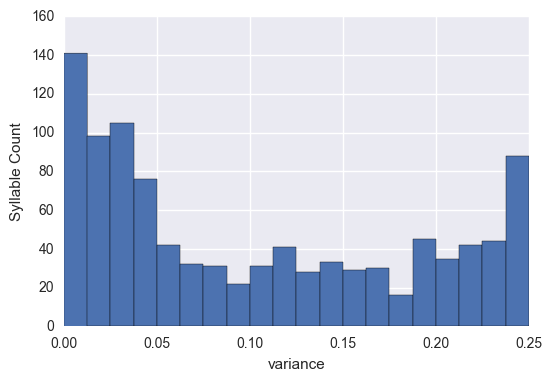

In [21]:
plt.hist(v,bins=20)
plt.xlabel('variance')
plt.ylabel('Syllable Count')

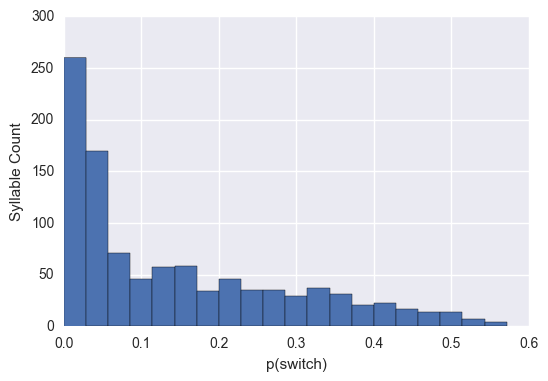

In [18]:
plt.hist(u_switch,bins=20)
plt.xlabel('p(switch)')
plt.ylabel('Syllable Count')

In [23]:
u_switch = np.asarray(u_switch)

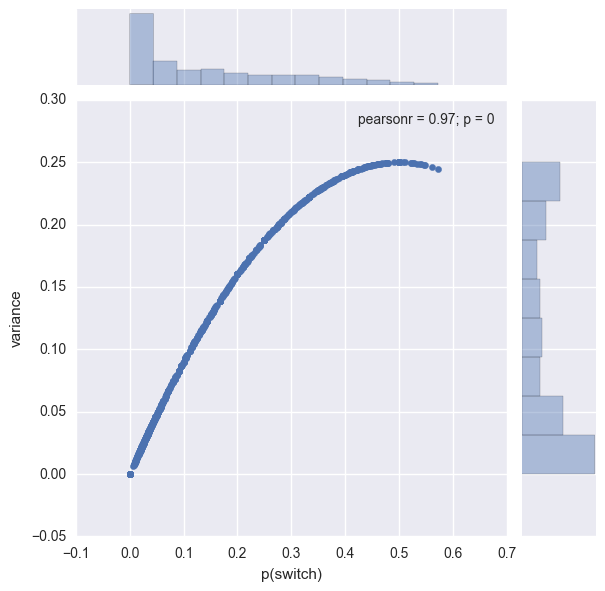

In [66]:
b = pd.DataFrame(data = {'syllable':unique,'p(switch)':u_switch,'variance':v})
plt.figure(figsize=(10,10))
sns.jointplot(x='p(switch)',y='variance',data=b)

In [49]:
b[b['p(switch)'] > 0.5]

,p(switch),syllable,variance
66,0.548387,0. 0. 0. 1. 0. 0. 1. 0. 0. 0.,0.247659
97,0.538462,0. 0. 0. 1. 1. 0. 1. 0. 0. 0.,0.248521
112,0.541667,0. 0. 0. 1. 1. 1. 1. 0. 0. 0.,0.248264
166,0.545455,0. 0. 1. 0. 1. 1. 0. 0. 0. 0.,0.247934
197,0.571429,0. 0. 1. 1. 0. 1. 0. 0. 0. 0.,0.244898
229,0.511628,0. 0. 1. 1. 1. 1. 0. 0. 0. 0.,0.249865
245,0.533333,0. 1. 0. 0. 0. 0. 0. 0. 0. 0.,0.248889
506,0.560976,1. 0. 0. 0. 0. 0. 1. 0. 0. 0.,0.246282
538,0.521739,1. 0. 0. 0. 1. 0. 1. 0. 0. 0.,0.249527
562,0.527778,1. 0. 0. 1. 0. 0. 0. 0. 0. 0.,0.249228


In [65]:
b[b['syllable'] == ' 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.']

,p(switch),syllable,variance
0,0.355263,0. 0. 0. 0. 0. 0. 0. 0. 0. 0.,0.229051


In [71]:
b[b['syllable'] == ' 1.  1.  1.  0.  0.  0.  0.  0.  0.  0.']

,p(switch),syllable,variance
881,0.369863,1. 1. 1. 0. 0. 0. 0. 0. 0. 0.,0.233064


In [137]:
b.shape

(1009, 3)

## Save df_combos

In [227]:
df_combos.to_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/syllables.csv')

In [49]:
data[data['Switch']==1]['1_']

,Mouse ID,Session ID,Block Trial,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,10_trialDuration,9_Port,...,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision,Switch,Higher p port,Reward,Condition
0,K1,11042016_K1,11.0,9.0,-1.0,0.0,0.0,15.781,1.542,1.0,...,1.0,0.0,1.346,0.674,1.087,1.0,0.0,1.0,1.0,90-10
1,K1,11042016_K1,12.0,10.0,1.0,1.0,1.0,3.252,0.880,1.0,...,1.0,1.0,1.087,0.574,1.584,1.0,0.0,1.0,1.0,90-10
2,K1,11042016_K1,13.0,10.0,2.0,1.0,1.0,1.294,0.805,1.0,...,1.0,1.0,1.584,0.646,5.985,1.0,0.0,1.0,1.0,90-10
3,K1,11042016_K1,14.0,10.0,3.0,1.0,1.0,2.992,0.787,1.0,...,1.0,1.0,5.985,0.552,1.062,1.0,0.0,1.0,1.0,90-10
4,K1,11042016_K1,15.0,10.0,4.0,1.0,1.0,1.058,0.689,1.0,...,1.0,1.0,1.062,0.664,1.122,1.0,0.0,1.0,0.0,90-10


### Fraction of ports included when only considering port streak >= 01

In [74]:
data[data['Port Streak'] == 10].shape[0] / data.shape[0]

0.5285144604901467

# Breaking it down by mouse

In [75]:
df_combos.head(5)

,Syllable,Decision,Mouse ID,Condition,Switch,Port Streak
0,0. 1. 1. 1. 1. 1. 1. 1. 1. 0.,1.0,K1,90-10,0.0,9.0
1,1. 1. 1. 1. 1. 1. 1. 1. 0. 1.,1.0,K1,90-10,0.0,10.0
2,1. 1. 1. 1. 1. 1. 1. 0. 1. 1.,1.0,K1,90-10,0.0,10.0
3,1. 1. 1. 1. 1. 1. 0. 1. 1. 1.,1.0,K1,90-10,0.0,10.0
4,1. 1. 1. 1. 1. 0. 1. 1. 1. 1.,1.0,K1,90-10,0.0,10.0


In [92]:
syllables = np.unique(df_combos['Syllable'].values)
mice = np.unique(df_combos['Mouse ID'].values)
conditions = np.unique(df_combos['Condition'].values)

u_switch = []
mice_list = []
syllable_list = []
N = []
condition_list = []

for syllable in syllables:
    for condition in conditions:
        for mouse in mice:
            
            bool_statement = ((df_combos['Syllable'] == syllable) 
                              & (df_combos['Mouse ID'] == mouse)
                              & (df_combos['Condition'] == condition))
            
            u_switch.append(df_combos[bool_statement]['Switch'].mean())
            N.append(df_combos[bool_statement]['Switch'].shape[0])
            mice_list.append(mouse)
            syllable_list.append(u)

In [128]:
syllable = syllables[0]
mouse = mice[0]
condition = '90-10'

bool_statement = ((df_combos['Syllable'] == syllable) 
                    & (df_combos['Mouse ID'] == mouse)
                    & (df_combos['Condition'] == condition))

bool_statement = ((df_combos['Syllable'] == syllable)
                    & (df_combos['Mouse ID'] == mouse))
                    #& (df_combos['Condition'] == condition))

df_combos[bool_statement]

,Syllable,Decision,Mouse ID,Condition,Switch,Port Streak
59,0. 0. 0. 0. 0. 0. 0. 0. 0. 0.,1.0,K1,90-10,0.0,10.0


In [119]:
syllables[0]

' 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.'

In [94]:
for syllable in syllables:
    for condition in conditions:
        for mouse in mice:
            condition_list.append(condition)

In [93]:
v = np.zeros(len(u_switch))

for i,u in enumerate(u_switch):
    v[i] = u*(1-u)

In [95]:
syllable_df = pd.DataFrame(data = {'syllable':syllable_list,'p(switch)':u_switch,'variance':v,'Mouse ID':mice_list,'N':N,'Condition':condition_list})

In [96]:
syllable_df.head(10)

,Condition,Mouse ID,N,p(switch),syllable,variance
0,70-30,K1,0,NaN,1. 0. 1. 1. 0. 0. 0. 1. 1. 0.,NaN
1,70-30,dumble,0,NaN,1. 0. 1. 1. 0. 0. 0. 1. 1. 0.,NaN
2,70-30,harry,1,1.00,1. 0. 1. 1. 0. 0. 0. 1. 1. 0.,0.0000
3,70-30,q40,0,NaN,1. 0. 1. 1. 0. 0. 0. 1. 1. 0.,NaN
4,70-30,q43,0,NaN,1. 0. 1. 1. 0. 0. 0. 1. 1. 0.,NaN
5,70-30,q45,0,NaN,1. 0. 1. 1. 0. 0. 0. 1. 1. 0.,NaN
6,70-30,quirrel,0,NaN,1. 0. 1. 1. 0. 0. 0. 1. 1. 0.,NaN
7,70-30,sprout,1,0.00,1. 0. 1. 1. 0. 0. 0. 1. 1. 0.,0.0000
8,70-30,tom,4,0.25,1. 0. 1. 1. 0. 0. 0. 1. 1. 0.,0.1875
9,70-30,tonks,2,0.00,1. 0. 1. 1. 0. 0. 0. 1. 1. 0.,0.0000


In [135]:
df_combos[df_combos['Syllable'] == syllables[0]]

,Syllable,Decision,Mouse ID,Condition,Switch,Port Streak
59,0. 0. 0. 0. 0. 0. 0. 0. 0. 0.,1.0,K1,90-10,0.0,10.0
4501,0. 0. 0. 0. 0. 0. 0. 0. 0. 0.,0.0,q40,90-10,0.0,9.0
4502,0. 0. 0. 0. 0. 0. 0. 0. 0. 0.,0.0,q40,90-10,0.0,10.0
4503,0. 0. 0. 0. 0. 0. 0. 0. 0. 0.,0.0,q40,90-10,0.0,10.0
4504,0. 0. 0. 0. 0. 0. 0. 0. 0. 0.,0.0,q40,90-10,0.0,10.0
4505,0. 0. 0. 0. 0. 0. 0. 0. 0. 0.,0.0,q40,90-10,0.0,10.0
4697,0. 0. 0. 0. 0. 0. 0. 0. 0. 0.,0.0,q40,90-10,0.0,2.0
4698,0. 0. 0. 0. 0. 0. 0. 0. 0. 0.,0.0,q40,90-10,0.0,3.0
4699,0. 0. 0. 0. 0. 0. 0. 0. 0. 0.,0.0,q40,90-10,0.0,4.0
4700,0. 0. 0. 0. 0. 0. 0. 0. 0. 0.,0.0,q40,90-10,0.0,5.0


In [111]:
syllable_df[syllable_df['syllable'] == syllable_list[0]].shape

(33792, 6)

In [133]:
syllable_df.pivot(index='Condition',columns='Mouse ID',values='syllable')

ValueError: Index contains duplicate entries, cannot reshape

In [148]:
from collections import Counter
condition_counts = Counter(data[data['Mouse ID']=='harry']['Condition'].values)

In [149]:
condition_counts

Counter({'70-30': 2353, '80-20': 6764, '90-10': 564})